In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from VQLSSVM import VQLSSVM

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

np.set_printoptions(precision=4, suppress=True)

In [2]:
shots: int = 10000
gamma: float = 0.01 # regularization parameter
subsetSize: int = 7
classToFilterOut: int = 2

In [3]:
def prepareDataset(normalizeValues: bool = False, dataset: str = "iris") -> (np.ndarray, np.ndarray, np.array, np.array):
    if dataset == "iris":
        X,y = datasets.load_iris(return_X_y=True)
        X = X[y!=classToFilterOut]
        y = y[y!=classToFilterOut]
    elif dataset == "breastCancer":
        X,y = datasets.load_breast_cancer(return_X_y=True)
    elif dataset == "dummyData":
        X, y = datasets.make_classification(
            n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
        )
    elif dataset == "digits":
        X, y = datasets.load_digits(n_class=2, return_X_y=True)
    elif dataset == "wine":
        X, y = datasets.load_wine(return_X_y=True) # 3 classes; filter out some class
    else: 
        raise ValueError("Dataset not yet implemented")
    y: np.array = np.where(y == 0, -1, 1) # might cause some problems in a future

    if normalizeValues: # normalize values returns nan with digits dataset
        max = np.max(X, axis=0)
        min = np.min(X, axis=0)
        X = (2*X - min - max) / (max - min)
    return train_test_split(X, y, test_size=(X.shape[0]-subsetSize)/(X.shape[0]), random_state=43)

In [4]:
xTrain, xTest, yTrain, yTest = prepareDataset(normalizeValues=True, dataset="iris")
print(xTrain)

[[ 0.5556  0.      0.7073  0.6471]
 [-0.1852  0.5833 -0.8537 -0.6471]
 [ 0.7037 -0.25    0.7561  0.4118]
 [-0.4074  0.4167 -0.7561 -0.6471]
 [-0.4815  0.0833 -0.8049 -0.8824]
 [-0.037  -0.25    0.2683  0.4118]
 [ 0.4074 -0.8333  0.7073  0.6471]]


# VQLS-LSSVM state vectors

Condition number of the matrix:  1549.1963269879666
LS-SVM Matrix:
 [[  0.       1.       1.       1.       1.       1.       1.       1.    ]
 [  1.     101.2276  -1.1254   1.1922  -1.1798  -1.4077   0.4356   1.1453]
 [  1.      -1.1254 101.522   -1.188    1.3826   1.3958  -0.6344  -1.584 ]
 [  1.       1.1922  -1.188  101.2989  -1.229   -1.3315   0.4088   1.2963]
 [  1.      -1.1798   1.3826  -1.229  101.33     1.4104  -0.5584  -1.4667]
 [  1.      -1.4077   1.3958  -1.3315   1.4104 101.6651  -0.5823  -1.4058]
 [  1.       0.4356  -0.6344   0.4088  -0.5584  -0.5823 100.3054   0.6494]
 [  1.       1.1453  -1.584    1.2963  -1.4667  -1.4058   0.6494 101.7794]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
Pauli matrix coeffitients [(88.64105774546628+0j), (0.4679490309569777+0j),

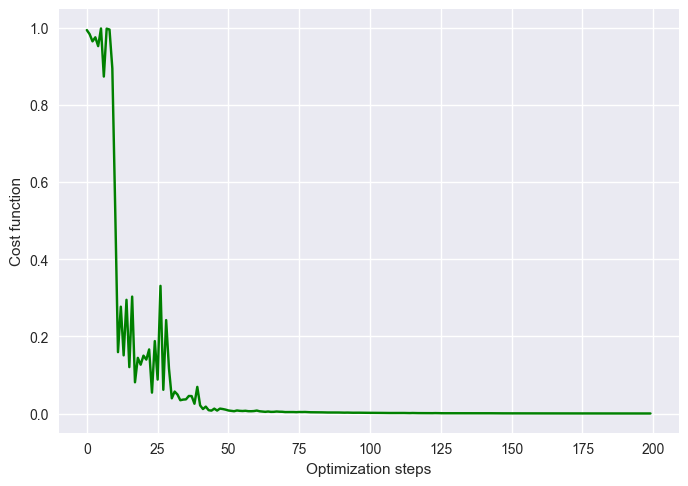

In [6]:
vqlssvmVectors: VQLSSVM = VQLSSVM(gamma, shots)
vqlssvmVectors.train(xTrain, yTrain, quantumSimulation=False, verbose=True, iterations = 200, method="COBYLA")
vqlssvmVectors.plotCost()

In [7]:
costCOBYLA = vqlssvmVectors.getCostHistory()
print("Cost history:")
print(costCOBYLA)

Cost history:
[0.9945056407886269, 0.9837124901735951, 0.965235765667874, 0.9757156546631709, 0.9528611151840303, 0.9986283821318729, 0.8739095266085464, 0.998183509398499, 0.9958328098653775, 0.8955340533450151, 0.5364183754559713, 0.15920115667854984, 0.277064882912719, 0.15087610810325391, 0.29490352980318046, 0.12035266347226259, 0.30322389360477253, 0.0810275573570095, 0.14434862862285747, 0.12664839498205172, 0.15007982194081138, 0.1398423703439985, 0.16624790050080196, 0.054188978043051006, 0.1878821017998804, 0.08799251360886418, 0.33110215800954923, 0.06157911152620921, 0.242314849061529, 0.11660486091420619, 0.039525928750765105, 0.05693121914447574, 0.049349443610125276, 0.03448672057397373, 0.036171139214612014, 0.03674851698794945, 0.04548729451744071, 0.045268119539537244, 0.025439594022306222, 0.06909348163306905, 0.021150123084822225, 0.011636517304484673, 0.01793796194798858, 0.008685043625025868, 0.007500768421912829, 0.01268919188929496, 0.00768853596692054, 0.012786

In [8]:
print(vqlssvmVectors.predict(xTest))

[-0.0647+0.j -0.1207+0.j  0.0018+0.j -0.1148+0.j -0.055 +0.j  0.0898+0.j
  0.0064+0.j  0.0534+0.j -0.0965+0.j -0.0005+0.j -0.1141+0.j -0.145 +0.j
  0.1103+0.j -0.0834+0.j  0.0131+0.j -0.1603+0.j -0.0313+0.j -0.118 +0.j
  0.0498+0.j  0.0941+0.j -0.0444+0.j -0.127 +0.j  0.0811+0.j  0.0342+0.j
 -0.0921+0.j  0.0283+0.j  0.076 +0.j  0.1259+0.j  0.0879+0.j -0.0621+0.j
 -0.1469+0.j -0.0292+0.j -0.1186+0.j -0.0611+0.j -0.0312+0.j -0.0553+0.j
  0.0746+0.j -0.0853+0.j -0.0871+0.j -0.1081+0.j  0.0094+0.j -0.0715+0.j
 -0.0261+0.j -0.135 +0.j -0.0065+0.j  0.1308+0.j -0.0626+0.j  0.0281+0.j
 -0.0755+0.j -0.0559+0.j -0.0871+0.j  0.1133+0.j  0.049 +0.j  0.0461+0.j
 -0.0786+0.j  0.1031+0.j  0.0568+0.j -0.1113+0.j -0.107 +0.j -0.0652+0.j
 -0.1711+0.j  0.0879+0.j -0.1242+0.j -0.0138+0.j  0.0031+0.j  0.1436+0.j
  0.0719+0.j -0.0901+0.j -0.0836+0.j  0.0408+0.j  0.1466+0.j -0.0607+0.j
  0.0302+0.j -0.064 +0.j  0.0856+0.j -0.0496+0.j -0.1223+0.j  0.1195+0.j
 -0.0674+0.j -0.0832+0.j  0.0265+0.j  0.0574+0.j -0

In [9]:
print("Accuracy:",vqlssvmVectors.accuracy(xTest, yTest))

Accuracy: 0.9139784946236559


# VQLS-LSSVM quantum

Condition number of the matrix:  1549.1963269879666
LS-SVM Matrix:
 [[  0.       1.       1.       1.       1.       1.       1.       1.    ]
 [  1.     101.2276  -1.1254   1.1922  -1.1798  -1.4077   0.4356   1.1453]
 [  1.      -1.1254 101.522   -1.188    1.3826   1.3958  -0.6344  -1.584 ]
 [  1.       1.1922  -1.188  101.2989  -1.229   -1.3315   0.4088   1.2963]
 [  1.      -1.1798   1.3826  -1.229  101.33     1.4104  -0.5584  -1.4667]
 [  1.      -1.4077   1.3958  -1.3315   1.4104 101.6651  -0.5823  -1.4058]
 [  1.       0.4356  -0.6344   0.4088  -0.5584  -0.5823 100.3054   0.6494]
 [  1.       1.1453  -1.584    1.2963  -1.4667  -1.4058   0.6494 101.7794]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
Pauli matrix coeffitients [(88.64105774546628+0j), (0.4679490309569777+0j),

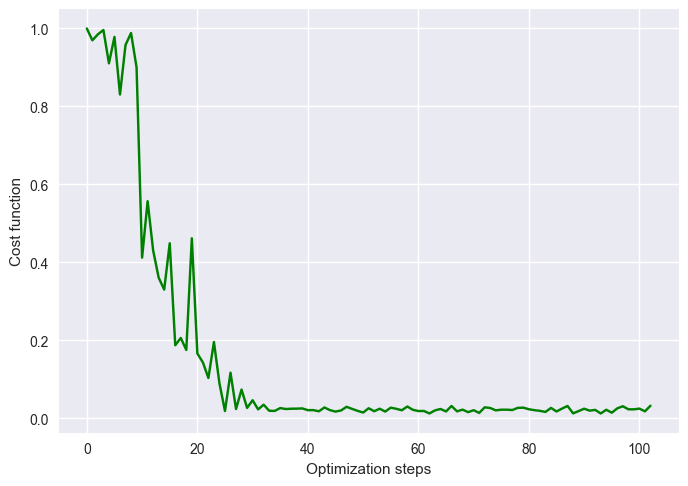

In [10]:
vqlssvmQuantum: VQLSSVM = VQLSSVM(gamma, shots)
vqlssvmQuantum.train(xTrain, yTrain, quantumSimulation=True, verbose=True, iterations = 200)

vqlssvmQuantum.plotCost()

In [11]:
costCOBYLA = vqlssvmQuantum.getCostHistory()
print("Cost history:")
print(costCOBYLA)
import csv

with open('costCOBYLA.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Iteration', 'CostFunction'])
    for i in range(len(costCOBYLA)):
        writer.writerow([i, costCOBYLA[i]])


Cost history:
[0.9998461812936489, 0.9695236784647456, 0.9847470738887636, 0.9960148813983697, 0.9104827737095933, 0.9783373099781228, 0.8304781193496773, 0.9574785455360241, 0.9882201838703655, 0.8997430419803502, 0.41213042760113416, 0.5569222401903775, 0.43069824413911184, 0.36076182330558526, 0.33011340230735076, 0.4490251192880915, 0.18743494859434218, 0.2061830133170952, 0.17543625774117932, 0.4617753442406052, 0.16630278802570264, 0.14353238254885936, 0.10348081559296562, 0.1958302208020456, 0.08959185043630247, 0.01879389888443117, 0.11706415121808533, 0.023952014228303176, 0.07390513391409415, 0.026741124936132787, 0.04644890810151936, 0.022931959397974766, 0.03501777509592241, 0.019488246073753324, 0.019045428766382377, 0.026390364171184455, 0.023903299956961943, 0.024681061847144137, 0.024875546528871473, 0.025429210029597527, 0.020980354657614164, 0.021090576553077223, 0.01810043764047853, 0.02790347743784094, 0.02100143452803671, 0.017352280208556503, 0.020211917961872383,

In [12]:
print("Predictions:\n", vqlssvmQuantum.predict(xTest))
print("Accuracy: ", vqlssvmQuantum.accuracy(xTest, yTest))

Predictions:
 [-0.0298+0.j -0.1039+0.j  0.0903+0.j -0.0784+0.j -0.0792+0.j  0.1092+0.j
 -0.0053+0.j  0.0594+0.j -0.0667+0.j -0.0068+0.j -0.0992+0.j -0.1414+0.j
  0.1482+0.j -0.0468+0.j -0.0009+0.j -0.1573+0.j  0.0287+0.j -0.1101+0.j
  0.0664+0.j  0.0966+0.j  0.0088+0.j -0.1188+0.j  0.0928+0.j  0.0327+0.j
 -0.0506+0.j  0.023 +0.j  0.0904+0.j  0.1615+0.j  0.1024+0.j -0.0083+0.j
 -0.1482+0.j  0.0484+0.j -0.1125+0.j -0.0087+0.j  0.037 +0.j -0.0841+0.j
  0.0856+0.j -0.0537+0.j -0.0559+0.j -0.0818+0.j -0.014 +0.j -0.0474+0.j
  0.0317+0.j -0.1205+0.j -0.0249+0.j  0.1597+0.j -0.0307+0.j  0.0307+0.j
 -0.0377+0.j -0.0057+0.j -0.0528+0.j  0.1388+0.j  0.0591+0.j  0.0604+0.j
 -0.0493+0.j  0.1137+0.j  0.0637+0.j -0.0931+0.j -0.0974+0.j -0.0325+0.j
 -0.2057+0.j  0.0821+0.j -0.1127+0.j -0.0316+0.j -0.0218+0.j  0.1663+0.j
  0.0869+0.j -0.0592+0.j -0.0517+0.j  0.0451+0.j  0.1779+0.j -0.0113+0.j
  0.0298+0.j -0.1083+0.j  0.1015+0.j  0.0218+0.j -0.1058+0.j  0.1343+0.j
 -0.0282+0.j -0.0419+0.j  0.0207+0.j 

# LSSVM (work in progresss)

In [13]:
# lssvmMatrix1: np.ndarray = lssvmMatrix(xTrain, gamma, "linearKernel")
# yVector: np.array = prepareLabels(yTrain)
# print(yVector)
# print ("Condition number of the matrix: ", np.linalg.cond(lssvmMatrix1))
# print("LS-SVM Matrix:\n", lssvmMatrix1)
# print(yVector)

# solution: np.array = np.linalg.solve(lssvmMatrix1, yVector)
# print("Solution:", solution)
# print ("Norm of the solution: ",solution/np.linalg.norm(solution))

# bias: float = solution[0]
# weights: np.array = solution[1:]

# vqlssvmLSSVM: VQLSSVM = VQLSSVM(gamma,10)
# vqlssvmLSSVM.xTrain = xTrain
# vqlssvmLSSVM.xTrainSize = xTrain.shape[0]
# vqlssvmLSSVM.weights = weights
# vqlssvmLSSVM.b = bias
# predictions: np.array = vqlssvmLSSVM.predict(xTest)
# classVals = [vqlssvmLSSVM.assignClass(i) for i in predictions]
# print("Predictions:", predictions)
# print("Class values:", classVals)
# print("yTest:", yTest)
# # print(yTest)
# print("Accuracy:", vqlssvmLSSVM.accuracy(xTest, yTest))

# Classical SVM

In [14]:
clf = SVC(kernel='linear')
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTest)
print("Accuracy:", accuracy_score(yTest, yPred))

Accuracy: 1.0
